# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
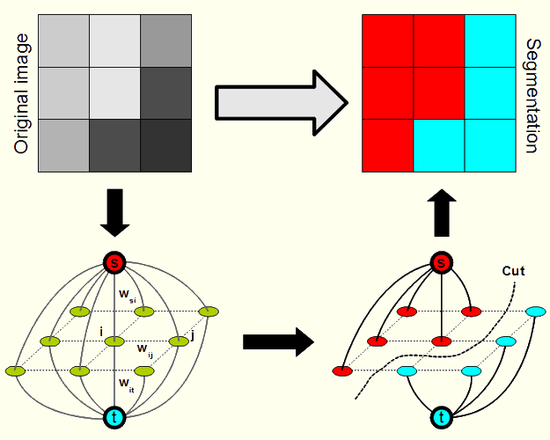

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2

from sklearn.mixture import GaussianMixture
from igraph import Graph
from matplotlib import pyplot as plt

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [70]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = 2*np.ones(img.shape[:2], dtype = np.uint8) # mask is a trinary array with : 0 - background pixels
                                                      #                                1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)            # output image to be shown       2 - unknown pixels

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    im_mask = np.zeros(img.shape[:2])
    
    while(1):
        
        img = EventObj.image
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = 2*np.ones(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            im_mask = np.zeros(img.shape[:2])
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            print('Segmentation started!!!\n')
            
            # Params
            h, w, _ = img2.shape
            K = 5
            gamma = 50
            iters = 3
            
            # Rectangle and strokes info
            y, x, dy, dx = EventObj.flags['RECT']
            event_mask = EventObj.mask
            
            # Initial alpha mask
            alpha = np.zeros((h, w))
            alpha[x:x+dx, y:y+dy] = 1
            alpha[np.where(event_mask == 0)] = 0
            alpha[np.where(event_mask == 1)] = 2
            
            # Collapsed indices
            im_ver = np.arange(h*w).reshape(h, w)
            
            # Initiating sets for fg, bg, un
            T_B = np.where(alpha == 0)
            bg_ver = im_ver[T_B].reshape(-1, 1)
            bg_px = img2[T_B]
            
            T_U = np.where(alpha == 1)
            un_ver = im_ver[T_U].reshape(-1, 1)
            un_px = img2[T_U]
            
            T_F = np.where(alpha == 2)
            fg_ver = im_ver[T_F].reshape(-1, 1)
            fg_px = img2[T_F]
            
            # Initiating Gaussian Mixtures
            gmm_bg = GaussianMixture(n_components=K)
            gmm_un = GaussianMixture(n_components=K)
            
            # Computing the distances of adjacent pixels (8-connectivity)
            norm_h = np.sum((img2[:, :-1] - img2[:, 1:])**2, axis=2).reshape(-1, 1)
            norm_v = np.sum((img2[:-1, :] - img2[1:, :])**2, axis=2).reshape(-1, 1)
            norm_dl = np.sum((img2[:-1, :-1] - img2[1:, 1:])**2, axis=2).reshape(-1, 1)
            norm_dr = np.sum((img2[:-1, 1:] - img2[1:, :-1])**2, axis=2).reshape(-1, 1)
            
            # Calculating beta
            beta = 1/(2*(np.sum(norm_h) + np.sum(norm_v) + np.sum(norm_dl) + np.sum(norm_dr))/(4*h*w - 3*h - 3*w + 2))
            
            # Making edges and weights
            edge_h = np.hstack((im_ver[:, :-1].reshape(-1, 1), im_ver[:, 1:].reshape(-1, 1)))
            weights_h = gamma * np.exp(-beta * norm_h)
            edge_v = np.hstack((im_ver[:-1, :].reshape(-1, 1), im_ver[1:, :].reshape(-1, 1)))
            weights_v = gamma * np.exp(-beta * norm_v)
            edge_dl = np.hstack((im_ver[:-1, :-1].reshape(-1, 1), im_ver[1:, 1:].reshape(-1, 1)))
            weights_dl = gamma * np.exp(-beta * norm_dl)/np.sqrt(2)
            edge_dr = np.hstack((im_ver[:-1, 1:].reshape(-1, 1), im_ver[1:, :-1].reshape(-1, 1)))
            weights_dr = gamma * np.exp(-beta * norm_dr)/np.sqrt(2)
            
            edge_sb = np.hstack((bg_ver, np.ones(bg_ver.shape)*(h*w)))
            weights_sb = np.ones(bg_ver.shape)*gamma*9
            edge_tb = np.hstack((bg_ver, np.ones(bg_ver.shape)*(h*w+1)))
            weights_tb = np.zeros(bg_ver.shape)
            
            edge_sf = np.hstack((fg_ver, np.ones(fg_ver.shape)*(h*w)))
            weights_sf = np.zeros(fg_ver.shape)
            edge_tf = np.hstack((fg_ver, np.ones(fg_ver.shape)*(h*w+1)))
            weights_tf = np.ones(fg_ver.shape)*gamma*9
            
            edges = np.vstack((edge_h, edge_v, edge_dl, edge_dr, edge_sb, edge_tb, edge_sf, edge_tf))
            weights = np.vstack((weights_h, weights_v, weights_dl, weights_dr, weights_sb, weights_tb, weights_sf, weights_tf))

            # Linearizing the image vector
            tmp_im = img2.reshape(-1, 3)
            
            for i in range(iters):
                # Copy edges and weights
                tmp_edges = np.copy(edges)
                tmp_weights = np.copy(weights)
                
                # Fit pixels to Gaussian Mixtures
                gmm_bg.fit(tmp_im[bg_ver[:, 0]])
                gmm_un.fit(tmp_im[un_ver[:, 0]])
                
                # Obtaining edge weights of un pixels to source and terminal
                s_edge = np.hstack((un_ver, np.ones(un_ver.shape)*(h*w)))
                s_weight = -gmm_un.score_samples(tmp_im[un_ver[:, 0]]).reshape(-1, 1)
                
                t_edge = np.hstack((un_ver, np.ones(un_ver.shape)*(h*w+1)))
                t_weight = -gmm_bg.score_samples(tmp_im[un_ver[:, 0]]).reshape(-1, 1)
                
                tmp_e = np.vstack((edges, s_edge, t_edge)).astype(int)
                tmp_w = np.vstack((weights, s_weight, t_weight))
                
                # Initiating graph
                G = Graph()
                G.es['weight'] = 1
                G.add_vertices(h*w+2)
                G.add_edges(tmp_e)
                G.es['weight'] = tmp_w.flatten()
                
                # Graph min-cut
                cut = G.mincut(h*w, h*w+1, capacity='weight')
                
                # Obtaining new set of bg and un vertices (indices)
                bg_ver = np.array(cut[0])
                bg_ver = bg_ver[(bg_ver != h*w) & (bg_ver != h*w+1)].reshape(-1, 1)
                un_ver = np.array(cut[1])
                un_ver = un_ver[(un_ver != h*w) & (un_ver != h*w+1)].reshape(-1, 1)
                print('Iteration '+str(i+1)+' completed')
                
            # Preparing mask for the image
            alpha = np.zeros(h*w)
            alpha[un_ver] = 1
            im_mask = alpha.reshape(h, w)
            print('Segmentation done!!!\n')
            
        EventObj.flags = FLAGS
        mask2 = np.where((im_mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

# Demonstrations

---

K (number of GMM components) = 5\
gamma = 50\
iters (number of iterations) = 3

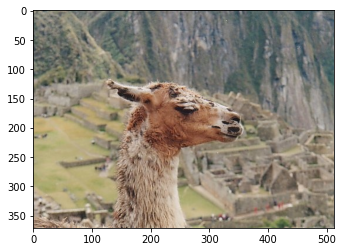

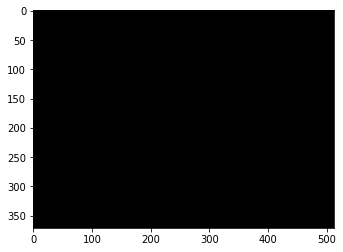

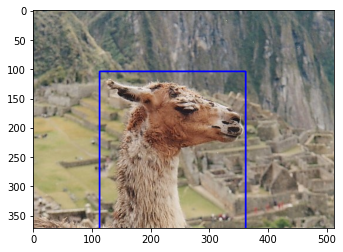

Segmentation started!!!

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



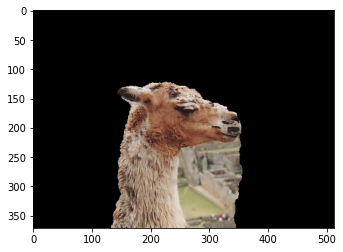

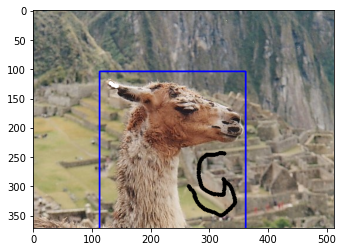

Segmentation started!!!

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



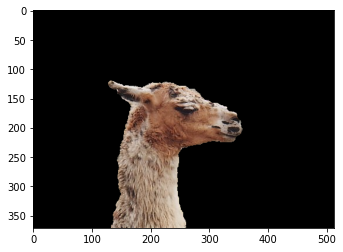

In [69]:
if __name__ == '__main__':
    filename = '../images/llama.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

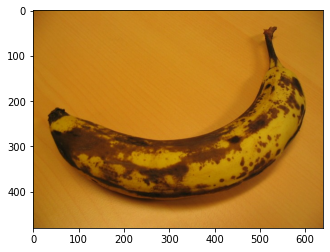

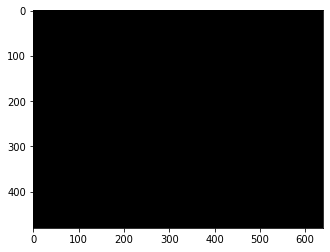

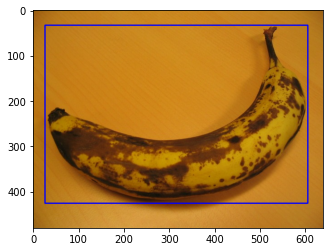

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



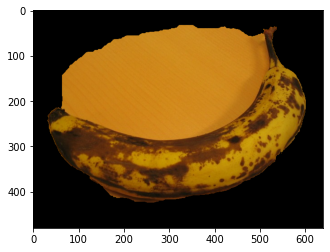

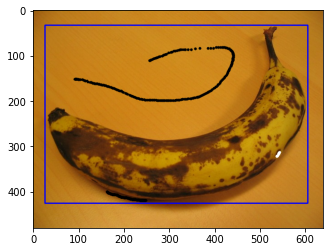

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



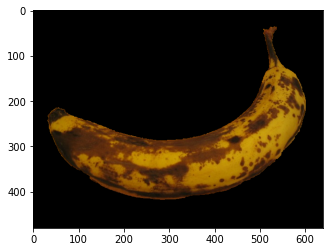

In [10]:
if __name__ == '__main__':
    filename = '../images/banana1.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

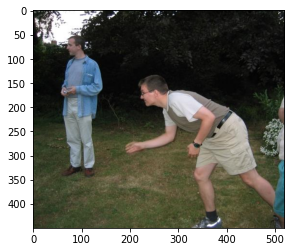

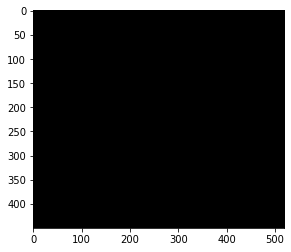

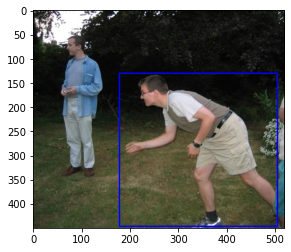

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



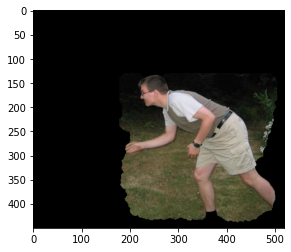

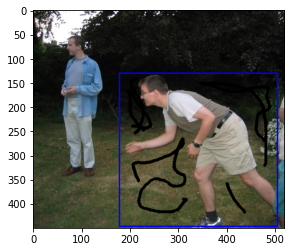

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



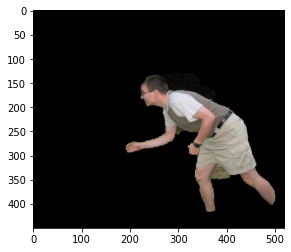

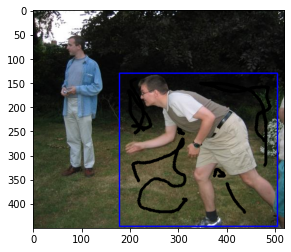

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



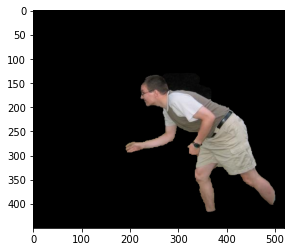

In [11]:
if __name__ == '__main__':
    filename = '../images/bool.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

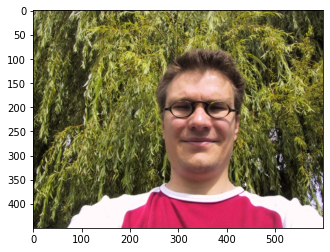

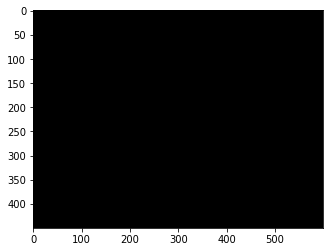

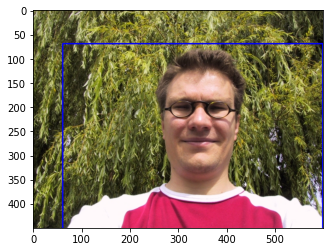

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



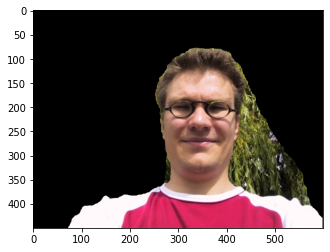

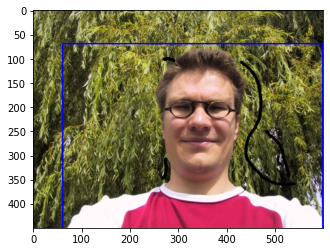

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



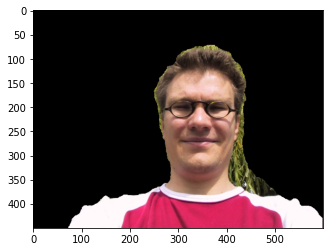

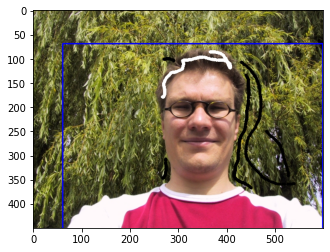

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



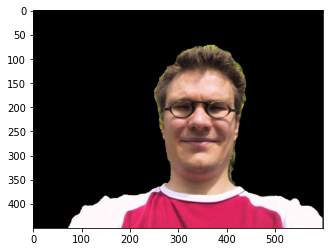

In [12]:
if __name__ == '__main__':
    filename = '../images/person1.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

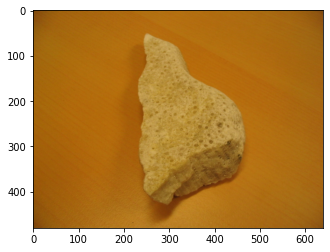

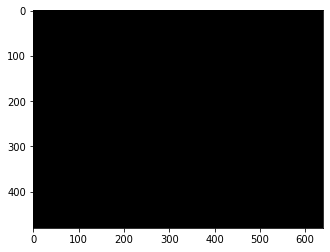

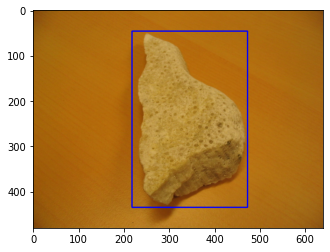

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



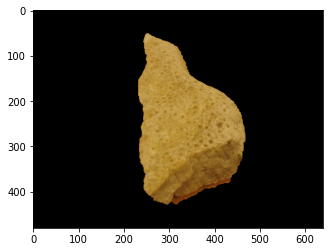

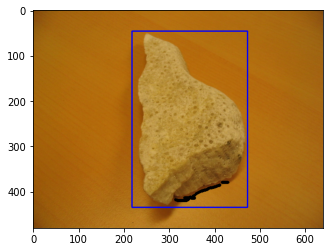

Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Segmentation done!!!



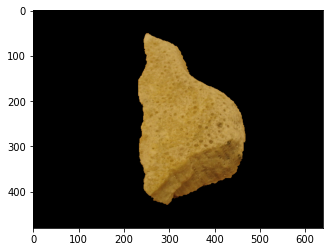

In [13]:
if __name__ == '__main__':
    filename = '../images/stone1.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()

# Report

---

### 1. The number of iterations of GMM updating and energy minimization
For this study on difference in segmentation with the number of iterations of GMM updating and energy minimization, I've used the image _book.jpg_.

![image](../images/iters.png)
As we can see from the above subplot of GrabCut segmentation, the number of iterations of GMM updating and energy minimization affects the amount of segmentation. As we know that GrabCut utilizes iterative approach for segmentation, the number of iterations is important. However, after certain number of iterations, further GMM updating and energy minimization is useless, because the energy saturates. Hence, first few iterations matter for GrabCut algorithm for proper segmentation. However, with changes in other parameters, the energy can saturate (attain minimum) at first iteration itself, then any further iterations might be useless.
![image](../images/energy.png)

### 2. The number of mixture components in your GMM
For this study on difference in segmentation with the number of mixture components in GMM, I've used the image _person4.jpg_.

The number of mixture components in the GMM is an important parameter which can affect the segmentation problem. As we know that the image won't be having similar pixels everywhere, the distribution will vary from image to image. For an image with many objects with varied colour intensity levels, it is important to increase number of mixture components because with less number of components, the GMM will learn a bad distribution from the image compared to mixture with high number of components.

![image](../images/K2.png)
The above segmented image is obtained with **_K = 2_**. We can see that the segmentation is quite aggressive. The haie region of the right person seems to cut off. The background region is present to the left of left person.

![image](../images/K20.png)
The above segmented image is obtained with **_K = 20_**. We can see that the segmentation is little better than the previous one. The hair of the right person is preserved. The background region is removed to the left of the left person.

Hence, with higher number of GMM components, the segmentation is better, because it fits the pixels with different distributions properly.

### 3. The choice of gamma
For this study on difference in segmentation with the choice of gamma, I've used the image _banana1.jpg_ and run the GrabCut algorithm for just 1 iteration.

![image](../images/gamma100.png)
The above segmented image is obtained with **_gamma = 100_**. We can see that some background pixels are also present in the segmented image, which means that the segmentation has not occured completely.

![image](../images/gamma500.png)
The above segmented image is obtained with **_gamma = 500_**. Here, we can see that compared to other image, the banana is segmented much better by eliminating most of the background pixels.

Hence, we can see a major difference of extra background being removed by using higher gamma value.